# Example usage

To use `locate` in a project:

In [1]:
import locate
print(locate.__version__)

0.1.0


In [1]:
import torch
import os
import pyro
from pyro.optim import Adam, ClippedAdam
from pyro.infer import TraceMeanField_ELBO, TraceEnum_ELBO, TraceGraph_ELBO, Trace_ELBO

import pandas as pd

## Start with a simple Clonal simulation

In [2]:
from locate.simulations.simulate import simulate_segment, simulate_data
from locate.simulations.utils_simulation import plot_simulations, create_data_input

In [3]:
purity = .7
coverage = 100
ploidy = 2

segs = simulate_segment(only_clonal = True, 
                        purity = purity, 
                        coverage = coverage, 
                        genome_size = 30000000)
snp,snv = simulate_data(segs)
data_input, snp, snv = create_data_input(snp, snv)

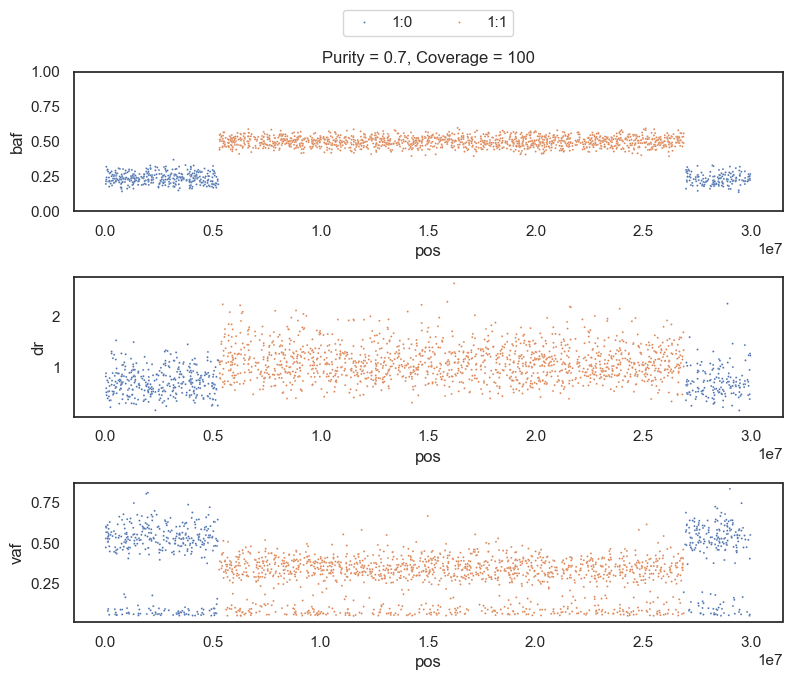

In [4]:
plot_simulations(snp, snv, purity, coverage)

## Do the inference

In [5]:
import locate.locate as l
from locate.models import Clonal
from locate.utils import plot_loss, plot_result

In [6]:
locate = l.LOCATE(CUDA = False)

locate.set_model(Clonal)
locate.set_optimizer(ClippedAdam)
locate.set_loss(TraceEnum_ELBO)
locate.initialize_model({"baf": data_input["baf"],
                         "dr": data_input["dr"], 
                         "dp_snp": data_input["dp_snp"], 
                         "vaf": data_input["vaf"], 
                         "dp": data_input["dp"]
                         })

locate.set_model_params({"jumping_prob" : 1e-6,
                         "fix_purity": False,
                         "prior_purity": purity,
                         "prior_ploidy": ploidy,
                         "scaling_factors": [1,1,1]})

/Users/lucreziavaleriani/opt/anaconda3/envs/locate/lib/python3.11/site-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


In [9]:
ll = locate.run(steps = 300, param_optimizer = {"lr" : 0.05})

ELBO: 4166.016292737  : 100%|██████████| 300/300 [00:04<00:00, 61.94it/s]


Done!


### Plot the loss

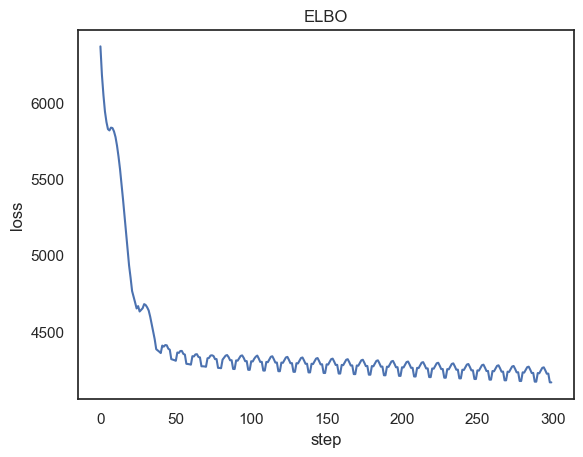

In [10]:
plot_loss(ll[0])

## Get results and plot them

In [11]:
params = locate.learned_parameters_Clonal()

In [12]:
res = pd.DataFrame({'CN_Major':params["CN_Major"]+0.05,
                    'CN_minor':params["CN_minor"]-0.05,
                    'pos':[i for i in range(len(params["CN_minor"]))]})

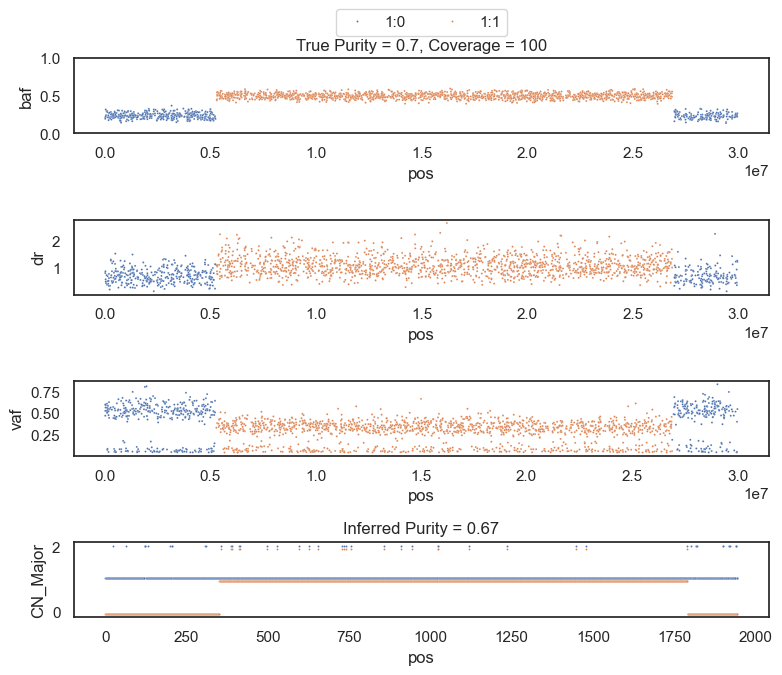

In [13]:
plot_result(res, snp, snv, purity, coverage, params)